**Bayesian Mixed Factor Analysis (BMFA)** is a statistical method that combines **factor analysis** with **Bayesian inference** to model complex relationships between observed data and latent factors. It is particularly useful when the dataset contains both **continuous** and **categorical** variables. BMFA estimates the latent factors that explain the correlations between observed variables while incorporating prior beliefs and updating them with observed data. This method handles uncertainty and allows for the inclusion of prior knowledge, making it ideal for small or incomplete datasets. It is commonly used in fields like psychometrics, marketing, and social sciences.

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd

In [ ]:
issuesvalues = pd.read_csv('data/issuevalue_short.csv')
issuesvalues.head()

,ideology,socialideology,economicideology,natsecurityideology,repealACA,approvekeystone,iransanctions,transpacificpartnershipact,normalizecubarelations,renewpatriotact,...,moraltrad.familyvalues,egalitarianism.equal,egalitarianism.toofar,egalitarianism.bigprob,egalitarianism.worryless,egalitarianism.notbigprob,egalitarianism.fewerprobs,militarism.strength,militarism.diplomacy,partyid
0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,5.0,1.0,4.0,1.0,5.0,2.0,2.0,2.0,1.0,3.0
1,3.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,...,5.0,1.0,5.0,5.0,2.0,3.0,2.0,3.0,3.0,7.0
2,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
4,NaN,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,NaN,...,1.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0


In [ ]:
# Create a separate 'partyid' variable
partyid = issuesvalues['partyid'].copy()  # Create a separate variable
party_mapping = {1: 1, 2: 1, 3: 1, 5: 2, 6: 2, 7: 2}  # Mapping 1,2,3 -> DEM(1), 5,6,7 -> REP(2)
partyid = partyid.map(party_mapping)
partyid[(partyid < 1) | (partyid > 2)] = np.nan  # Set other values to NaN

# Convert 'partyid' to a categorical variable with labels
partyid = pd.Categorical(partyid, categories=[1, 2], ordered=True)
partyid = partyid.rename_categories(["DEM", "REP"])

In [ ]:
ideology = issuesvalues['ideology'].copy

In [ ]:
issuesvalues = issuesvalues.drop('partyid', axis=1)
n_obs, n_vars = issuesvalues.shape

In [ ]:
# Bayesian Confirmatory Factor Analysis in PyMC
with pm.Model() as model:
    # Priors for latent factors
    factors = pm.Normal("factors", mu=0, sigma=1, shape=(n_obs, 2))

    # Priors for factor loadings (constrained to have positive impact for 'ideology')
    loadings = pm.Normal("loadings", mu=0, sigma=1, shape=(2, n_vars))
    loadings = pm.Deterministic("constrained_loadings", pm.math.switch(loadings[1, 1] < 0, -loadings, loadings))

    # Predicted data
    predictions = pm.math.dot(factors, loadings)

    # Likelihood
    sigma = pm.Exponential("sigma", 1)
    observed = pm.Normal("observed", mu=predictions, sigma=sigma, observed=issuesvalues)

    # Run MCMC
    trace = pm.sample(1000, tune=1000, thin=5, return_inferencedata=True)

# Inspect results
# az.plot_trace(trace)

/usr/local/lib/python3.11/dist-packages/pymc/model/core.py:1302: ImputationWarning: Data in observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

Output()

ERROR:pymc.stats.convergence:There were 324 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# Step 2: Extract Means and Standard Deviations
summary_stats = pm.summary(trace)  # Get the summary statistics
means_sds = summary_stats[['mean', 'sd']]  # Select means and standard deviations

# Filter rows related to "phi" (replace 'phi' with the actual prefix in your variable names if different)
ideal_points = means_sds[means_sds.index.str.contains("factors")]

# Split into two dimensions
irt1_means = ideal_points.iloc[::2, 0].values  # Every other row starting from the first
irt2_means = ideal_points.iloc[1::2, 0].values  # Every other row starting from the second

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (be

In [ ]:
# Step 3: Create a DataFrame
irtdt = pd.DataFrame({
    "coord1D": irt1_means,
    "coord2D": irt2_means,
    "party": partyid
})

# Filter for specific parties (DEM and REP)
irtdt_n = irtdt[irtdt["party"].isin(["DEM", "REP"])]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

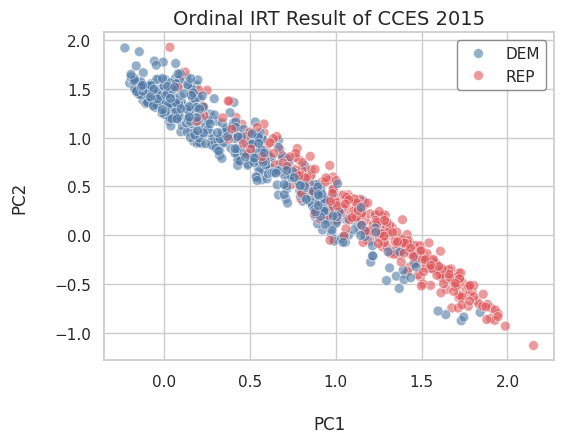

In [ ]:
# Step 4: Visualization
sns.set(style="whitegrid")
plt.figure(figsize=(5.8, 4.6))

# Define custom colors
party_colors = {"DEM": "#507AA6", "REP": "#DF585C"}

# Create scatterplot
sns.scatterplot(
    data=irtdt_n,
    x="coord1D",
    y="coord2D",
    hue="party",
    palette=party_colors,
    alpha=0.6,
    s=50  # Point size
)

# Customize plot appearance
plt.xlabel("\nPC1")
plt.ylabel("PC2\n")
plt.title("Ordinal IRT Result of CCES 2015", fontsize=14, ha="center")
plt.legend(title=None, loc="upper right", frameon=True, framealpha=0.9, edgecolor="gray")

# Save plot to PDF
plt.tight_layout()
plt.show()